In [1]:
import pandas as pd
import os

df = pd.read_csv('./styles.csv', on_bad_lines='skip').reset_index(drop=True)
df['id'] = df['id'].astype('str')

images_path = './images/'
all_images = os.listdir(images_path)

In [2]:
img_df = pd.DataFrame(all_images, columns=['image_id'])
img_df['id'] = img_df['image_id'].apply(lambda x: x.split('.')[0])

metadata = pd.merge(img_df, df, on='id', how='left')

In [3]:
metadata.head()

,image_id,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,10000.jpg,10000,Women,Apparel,Bottomwear,Skirts,White,Summer,2011.0,Casual,Palm Tree Girls Sp Jace Sko White Skirts
1,10001.jpg,10001,Women,Apparel,Bottomwear,Skirts,Blue,Summer,2011.0,Casual,Palm Tree Kids Girls Sp Jema Skt Blue Skirts
2,10002.jpg,10002,Women,Apparel,Bottomwear,Skirts,Blue,Summer,2011.0,Casual,Palm Tree Kids Sp Jema Skt Blue Skirts
3,10003.jpg,10003,Women,Apparel,Topwear,Tshirts,White,Fall,2011.0,Sports,Nike Women As Nike Eleme White T-Shirt
4,10004.jpg,10004,Men,Apparel,Bottomwear,Shorts,Grey,Fall,2011.0,Sports,Nike Men As 7 Sw Temp Grey Shorts


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing import image
import numpy as np
from tqdm import tqdm

# Load the pre-trained MobileNetV2 without the top classification layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Global Average Pooling layer to reduce dimensionality after base_model
global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()

# Function to preprocess images and extract feature vectors
def extract_features(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image

    # Extract features
    features = base_model(img_array)
    features = global_average_pooling(features)
    return features.numpy().flatten()  # Flatten the 2D output into a 1D vector

# Directory where images are stored
image_dir = images_path

# Extract feature vectors for all images
features = []
image_ids = []

for _, row in tqdm(metadata.iterrows()):
    image_path = os.path.join(image_dir, row['image_id'])
    features.append(extract_features(image_path))
    image_ids.append(row['image_id'])

# Convert list to numpy array
features = np.array(features)

44441it [55:10, 13.42it/s]


In [7]:
# Add the image IDs and features to the metadata DataFrame
metadata['feature_vector'] = list(features)

# Save this to a CSV file for later use
metadata.to_csv('fashion_with_features.csv', index=False)

In [14]:
metadata.head()

,image_id,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,feature_vector
0,10000.jpg,10000,Women,Apparel,Bottomwear,Skirts,White,Summer,2011.0,Casual,Palm Tree Girls Sp Jace Sko White Skirts,"[1.9962637, 0.036647037, 0.0, 0.07838154, 0.0,..."
1,10001.jpg,10001,Women,Apparel,Bottomwear,Skirts,Blue,Summer,2011.0,Casual,Palm Tree Kids Girls Sp Jema Skt Blue Skirts,"[1.2813798, 0.05679619, 0.062757045, 0.1358371..."
2,10002.jpg,10002,Women,Apparel,Bottomwear,Skirts,Blue,Summer,2011.0,Casual,Palm Tree Kids Sp Jema Skt Blue Skirts,"[0.4618144, 0.096180975, 0.25461653, 1.3642493..."
3,10003.jpg,10003,Women,Apparel,Topwear,Tshirts,White,Fall,2011.0,Sports,Nike Women As Nike Eleme White T-Shirt,"[1.1221386, 0.013512474, 0.0, 0.8041408, 0.0, ..."
4,10004.jpg,10004,Men,Apparel,Bottomwear,Shorts,Grey,Fall,2011.0,Sports,Nike Men As 7 Sw Temp Grey Shorts,"[0.022088664, 0.0, 0.0, 0.088092856, 0.1545880..."


In [22]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate similarity between an input image and the dataset
def get_similar_products(input_image_path, features, metadata, top_n=5):
    input_features = extract_features(input_image_path)  # Get feature vector of input image
    similarities = cosine_similarity([input_features], features)  # Compare to all features

    # Get the indices of the top N similar products
    similar_indices = similarities[0].argsort()[-top_n:][::-1]  # Sort and pick the top N

    # Get the image IDs and similarity scores of the top N products
    similar_products = metadata.iloc[similar_indices][['image_id','id', 'masterCategory', 'articleType']]
    similar_products['similarity'] = similarities[0][similar_indices]

    return similar_products

# Example usage: Get similar products to a new input image
input_image_path = './tshirt.jpg'
similar_products = get_similar_products(input_image_path, features, metadata, top_n=5)

print(similar_products)

        image_id     id masterCategory articleType  similarity
17340   3044.jpg   3044        Apparel     Tshirts    0.625639
44046   9533.jpg   9533        Apparel     Tshirts    0.621373
13835   2617.jpg   2617        Apparel     Tshirts    0.610186
42388   7546.jpg   7546        Apparel     Tshirts    0.609628
2341   12791.jpg  12791        Apparel     Tshirts    0.608816


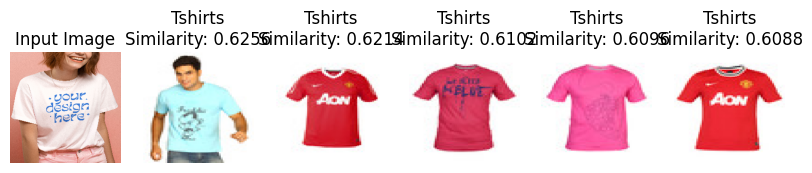

In [23]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def display_recommendations(input_image_path, similar_products):
    # Load and display the input image
    input_image = image.load_img(input_image_path, target_size=(224, 224))
    plt.figure(figsize=(10, 5))

    # Create a grid to display the input image and similar products
    gs = gridspec.GridSpec(1, len(similar_products) + 1, width_ratios=[1] * (len(similar_products) + 1))
    ax0 = plt.subplot(gs[0])
    ax0.imshow(input_image)
    ax0.set_title("Input Image")
    ax0.axis('off')

    for i, row in enumerate(similar_products.itertuples()):
        # Load and display the recommended image
        recommended_image_path = os.path.join(image_dir, row.image_id)
        recommended_image = image.load_img(recommended_image_path, target_size=(224, 224))

        ax = plt.subplot(gs[i + 1])
        ax.imshow(recommended_image)
        ax.set_title(f"{row.articleType}\nSimilarity: {row.similarity:.4f}")
        ax.axis('off')

    plt.show()

# Display recommendations for the input image
display_recommendations(input_image_path, similar_products)